# Template for coursework - Part 1 Classification

In [83]:
# import knihoven
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.tree import plot_tree


## Team identification

* seminar day and time
    
        ST 9:15

* team number

        Team D

* names of team members

        Michal Červinka, Filip Dvořák, Tomáš Jareš, Dominik Šimon

# Introduction

1.	Describe the business value of addressing this problem with machine learning.

        Použití strojového učení na dataset diabetu může výrazně přispět k zlepšení zdravotní péče. Umožňuje časnou detekci a diagnostiku diabetu, vytváření personalizovaných léčebných plánů, předpovídání pravděpodobnosti komplikací, stratifikaci pacientů na základě rizika a efektivní řízení a sledování nemoci. Tímto způsobem může strojové učení zlepšit klinické 
        rozhodování, výsledky pacientů a přispět k efektivnějšímu poskytování zdravotní péče.

2.	Provide the link to the source of the data.
        
        https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

## Customization


1.	What is the *target attribute*

        Diabetes

2.	What is the *instance of interest*   The instance can be identified, for example, by an id.

        Pro testování na jedné instaci jsme zvolili instaci, kde je přítomen diabetes (414)

3.	Choose an *attribute of interest* 

        Diabetes

5.	Show *Cost matrix* consisting of a cost of a false positive, false negative, true positive and true negative. Note that cost of true positive and true negative is recommended to be zero.

        Při detekování přitomnosti nemocí u pacientů jsou pro nás výrazně dražší false negatives než false positives, protože zanedbání léčby nebo podstoupení dalších testů je celkově dražší, než zybtečné další testování nebo nasazení léčby, která se později ukáže jako nepotřebná (toto pravidlo neplatí pro detekci všech nemocí ale pro případ diabetu dává smysl).

            Zvolili jsme si tedy ceny:

            False positive: 500

            False negative: 2000


In [84]:
false_positive_cost = 500
false_negative_cost = 2000

# Data Exploration

1. Describe meaning of individual attributes
2.	Show a histogram (or a table with value frequencies) for the target variable and for selected other variables. Try to convey the distributions of target variable for each predictor (e.g. by using stacked bar chart) 
3.	Show a scatterplot (correlation plot) showing the relation between selected predictors and the target variable
4.	Interpret the results


## Načtení datasetu


In [85]:
data = pd.read_csv("diabetes_prediction_dataset.csv")
data

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


## Data exploration

### Četnosti cílové proměnné

Text(0.5, 1.0, 'Cílová proměnná má_diabetes')

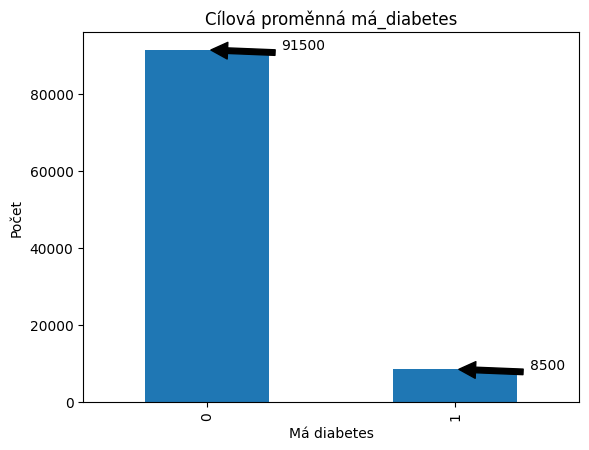

In [86]:
import matplotlib.pyplot as plt
#bar plot X axis = diabetes classes Y axis = count
data.groupby('diabetes').size().plot(kind='bar')
plt.xlabel('Má diabetes')
plt.ylabel('Počet')
count_diabetes_0 = data[data['diabetes'] == 0].shape[0]
count_diabetes_1 = data[data['diabetes'] == 1].shape[0]
plt.annotate(count_diabetes_0,xy=(0, count_diabetes_0),xytext=(0.3, count_diabetes_0),arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(count_diabetes_1,xy=(1, count_diabetes_1),xytext=(1.3, count_diabetes_1),arrowprops=dict(facecolor='black', shrink=0.05))
plt.title("Cílová proměnná má_diabetes")




Cílová proměnná je v datasetu nevyvážená. Budeme muset provést oversampling.

#### Histogramy ostatních proměnných

Never:  35095 35.095 %
No Info:  35816 35.815999999999995 %
Current:  9286 9.286 %
Former:  9352 9.352 %
Ever:  4004 4.004 %
Not current:  6447 6.447 %


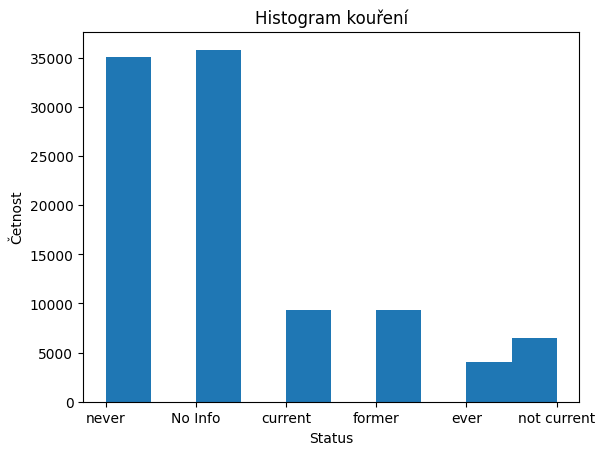

In [87]:
plt.hist(data['smoking_history'])
plt.title("Histogram kouření")
plt.xlabel("Status")
plt.ylabel("Četnost")
print("Never: ",data[data["smoking_history"] == "never"].shape[0], data[data["smoking_history"] == "never"].shape[0]/data.shape[0]*100,"%")
print("No Info: ",data[data["smoking_history"] == "No Info"].shape[0] , data[data["smoking_history"] == "No Info"].shape[0]/data.shape[0]*100,"%")
print("Current: ",data[data["smoking_history"] == "current"].shape[0], data[data["smoking_history"] == "current"].shape[0]/data.shape[0]*100,"%")
print("Former: ",data[data["smoking_history"] == "former"].shape[0], data[data["smoking_history"] == "former"].shape[0]/data.shape[0]*100,"%")
print("Ever: " ,data[data["smoking_history"] == "ever"].shape[0], data[data["smoking_history"] == "ever"].shape[0]/data.shape[0]*100,"%")
print("Not current: ", data[data["smoking_history"] == "not current"].shape[0], data[data["smoking_history"] == "not current"].shape[0]/data.shape[0]*100,"%")

Dataset obsahuje spoustu prázdných hodnot {No info}

Text(0, 0.5, 'Četnost')

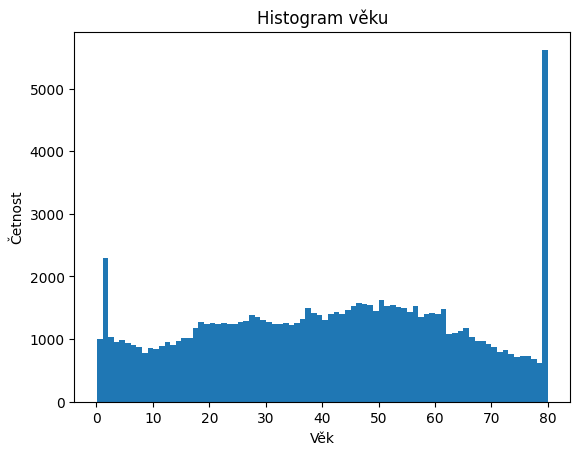

In [88]:
plt.hist(data['age'], bins=80)
plt.title("Histogram věku")
plt.xlabel("Věk")
plt.ylabel("Četnost")

In [89]:
import statistics
data['age_category'] = pd.cut(data['age'], bins=[0, 10, 20, 30, 40, 50, 60,70,80,], labels=['0-10', '11-20', '21-30', '31-40', '41-50', '51-60','61-70','71-80'])
print(statistics.mode(data['age_category']))
statistics.mode(data['age'])


51-60


80.0

Njevíce je zastoupeno věkové rozmezí 51-60 let. 
Pro jeden konkrétní věk je to 80 let.

Text(0.5, 0, 'BMI')

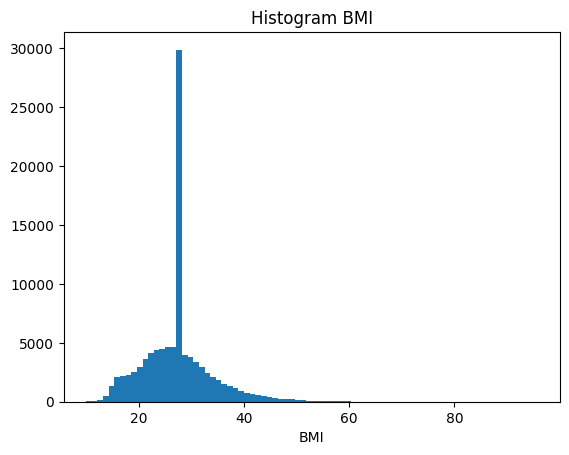

In [90]:
plt.hist(data['bmi'], bins=80)
plt.title("Histogram BMI")
plt.xlabel("BMI")


Text(0, 0.5, 'Četnost')

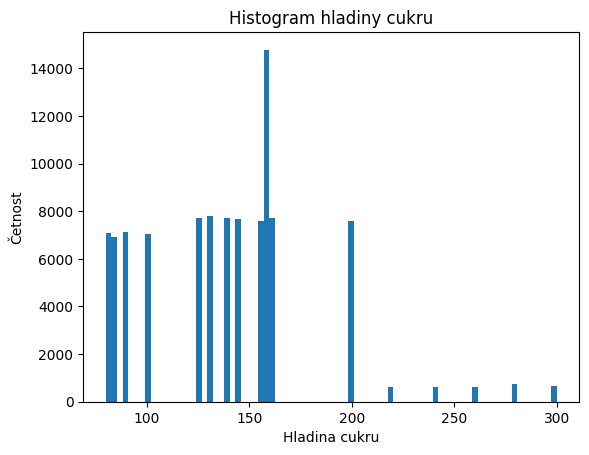

In [91]:
plt.hist(data['blood_glucose_level'], bins=80)
plt.title("Histogram hladiny cukru")
plt.xlabel("Hladina cukru")
plt.ylabel("Četnost")


#### Korelační grafy



Text(0, 0.5, 'Má diabetes')

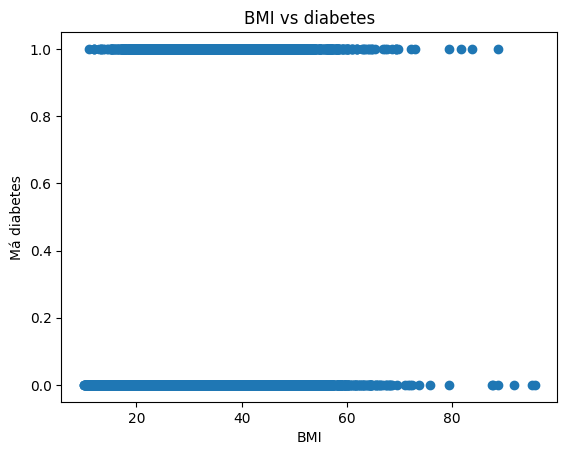

In [92]:
plt.scatter(data['bmi'],data['diabetes'])
plt.title("BMI vs diabetes")
plt.xlabel("BMI")
plt.ylabel("Má diabetes")


Text(0, 0.5, 'Má diabetes')

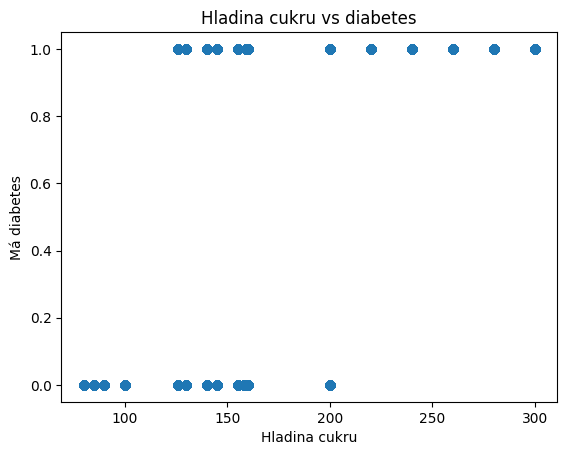

In [93]:
plt.scatter(data['blood_glucose_level'],data['diabetes'])
plt.title("Hladina cukru vs diabetes")
plt.xlabel("Hladina cukru")
plt.ylabel("Má diabetes")

Čím vyšší hladina cukru tím větší výskyt cukrovky


# Data preprocessing

## Preprocessing for supervised machine learning 

In [94]:
data = pd.read_csv("diabetes_prediction_dataset.csv")

#vybrání instance
instance_of_interest = data.iloc[414]
#odstranění instace aby ji model nemohl použít pro trénování
data.drop(414)



,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


### Derive binary target attribute (if not already binary)

Cílový atribut je již binární

#### Odstranění dat

Odstranění záznamů, kde je pohlaví určeno jako Other. Dataset obsahuje těchto instancí jen 16.

In [95]:
print ("Počet pro pohláví 'Other'",data[data['gender'] == 'Other'].shape[0])
data = data.drop(data[data['gender'] == 'Other'].index)

Počet pro pohláví 'Other' 18


### Train test split 

In [96]:
X = data.drop('diabetes', axis=1)
y = data['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set: ", X_train.shape)
print("Testing set: ", X_test.shape)

Training set:  (79985, 8)
Testing set:  (19997, 8)


### Feature engineering 

Do at least one additional data preprocessing, such as

-	Remove missing values
-	If the classes are imbalanced, you may upsample (or downsample) the training dataset.
-	Normalize values or use a standard scale 
-	Remove rows based on subsetting
-	Derive new columns
-	Perform feature selection (remove some attributes)


Make sure that your preprocessing operation does not use information from the test set. It is therefore recommended to “fit” preprocessing on the training set and then apply it on the test set.

#### Doplnění chybějících pozorování pro smoking_history

In [97]:
print(X_train['smoking_history'].value_counts())
print("celkem: " ,X_train['smoking_history'].shape[0])

smoking_history
No Info        28644
never          28030
former          7483
current         7472
not current     5139
ever            3217
Name: count, dtype: int64
celkem:  79985


In [98]:
value_counts = X_train[X_train['smoking_history'] != 'No Info']['smoking_history'].value_counts()
total_count = value_counts.sum()
distribution = (X_train['smoking_history'].value_counts() / total_count).drop('No Info')
random= np.random.choice(distribution.index,X_train[X_train['smoking_history'] == 'No Info'].shape[0] ,p=distribution.values)

X_train['smoking_history'].loc[X_train['smoking_history'] == 'No Info'] = random


C:\Users\filip\AppData\Local\Temp\ipykernel_26532\1581618481.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_train['smoking_history'].loc[X_train['smoking_history'] == 'No Info'] = random
C:\Users\filip\AppData\Local\Temp\ipykernel_265

In [99]:
print(X_train['smoking_history'].value_counts())
print("celkem: " ,X_train['smoking_history'].shape[0])

smoking_history
never          43769
current        11624
former         11586
not current     7947
ever            5059
Name: count, dtype: int64
celkem:  79985


#### Převedení kategoriálních hodnot na binární

##### Gender na binarní reprezentaci

In [100]:
X_train = pd.get_dummies(X_train, columns=['gender'])

X_train

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,gender_Female,gender_Male
48062,14.0,0,0,current,27.32,4.8,200,False,True
38243,3.0,0,0,current,19.99,6.1,130,False,True
3806,51.0,0,0,never,27.32,7.0,130,False,True
63147,28.0,0,0,ever,27.32,6.1,200,True,False
6006,10.0,0,0,never,17.70,6.6,100,False,True
...,...,...,...,...,...,...,...,...,...
6265,49.0,0,0,never,32.98,5.7,80,False,True
54896,58.0,0,0,never,27.32,6.6,140,True,False
76838,42.0,0,0,never,27.32,6.6,140,False,True
860,37.0,0,0,never,24.96,6.2,158,True,False


##### Smoking_history na binární reprezentaci

In [101]:
X_train = pd.get_dummies(X_train, columns=['smoking_history'])

X_train

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_Female,gender_Male,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
48062,14.0,0,0,27.32,4.8,200,False,True,True,False,False,False,False
38243,3.0,0,0,19.99,6.1,130,False,True,True,False,False,False,False
3806,51.0,0,0,27.32,7.0,130,False,True,False,False,False,True,False
63147,28.0,0,0,27.32,6.1,200,True,False,False,True,False,False,False
6006,10.0,0,0,17.70,6.6,100,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,49.0,0,0,32.98,5.7,80,False,True,False,False,False,True,False
54896,58.0,0,0,27.32,6.6,140,True,False,False,False,False,True,False
76838,42.0,0,0,27.32,6.6,140,False,True,False,False,False,True,False
860,37.0,0,0,24.96,6.2,158,True,False,False,False,False,True,False


#### Normalizace dat

In [102]:
X_train.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
count,79985.000000,79985.000000,79985.000000,79985.000000,79985.000000,79985.000000
mean,41.848169,0.075202,0.038895,27.310700,5.527780,137.992811
std,22.527146,0.263718,0.193345,6.642988,1.070549,40.686407
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000
25%,24.000000,0.000000,0.000000,23.600000,4.800000,100.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000
75%,60.000000,0.000000,0.000000,29.560000,6.200000,159.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000


In [103]:
scaler = MinMaxScaler()
X_train[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']] = scaler.fit_transform(X_train[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']])
X_train.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
count,79985.000000,79985.000000,79985.000000,79985.000000,79985.000000,79985.000000
mean,0.522625,0.075202,0.038895,0.201922,0.368687,0.263604
std,0.281871,0.263718,0.193345,0.077533,0.194645,0.184938
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.299299,0.000000,0.000000,0.158613,0.236364,0.090909
50%,0.537037,0.000000,0.000000,0.202031,0.418182,0.272727
75%,0.749750,0.000000,0.000000,0.228175,0.490909,0.359091
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Upsampling

In [104]:
# # #Syntetický upsampling pomocí SMOTE

# #definice pipeline
over = SMOTE(sampling_strategy=0.5, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5,random_state=42)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train, y_train = pipeline.fit_resample(X_train,y_train)



In [105]:
y_train.value_counts()

diabetes
0    73260
1    36630
Name: count, dtype: int64

## Applying preprocessing on test data

In [106]:
value_counts = X_test[X_test['smoking_history'] != 'No Info']['smoking_history'].value_counts()
total_count = value_counts.sum()
distribution = (X_test['smoking_history'].value_counts() / total_count).drop('No Info')
random= np.random.choice(distribution.index,X_test[X_test['smoking_history'] == 'No Info'].shape[0] ,p=distribution.values)

X_test['smoking_history'].loc[X_test['smoking_history'] == 'No Info'] = random


X_test = pd.get_dummies(X_test, columns=['smoking_history'])
X_test = X_test.drop(X_test[X_test['gender'] == 'Other'].index)
X_test = pd.get_dummies(X_test, columns=['gender'])
X_test[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']] = scaler.fit_transform(X_test[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']])

X_test.describe()

C:\Users\filip\AppData\Local\Temp\ipykernel_26532\2410801113.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_test['smoking_history'].loc[X_test['smoking_history'] == 'No Info'] = random
C:\Users\filip\AppData\Local\Temp\ipykernel_26532

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
count,19997.000000,19997.000000,19997.000000,19997.000000,19997.000000,19997.000000
mean,0.525121,0.073511,0.041556,0.202409,0.368459,0.265081
std,0.281247,0.260980,0.199578,0.077718,0.194755,0.185462
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.299299,0.000000,0.000000,0.159732,0.236364,0.090909
50%,0.537037,0.000000,0.000000,0.201928,0.418182,0.272727
75%,0.749750,0.000000,0.000000,0.228961,0.490909,0.359091
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Modeling

* Train the model on training data, and evaluate the model on test data. 
* Try at least two machine learning classification algorithms. It is recommended to try Decision Trees and Forests. 


### Classifier 1 (decision tree)

* Try various combinations of metaparameters (such as tree depth for decision tree) and record the impact on predictive performance. You can use grid search cross-validation for this.
* Once you determine the best values, you can refit the model with the best parameter value on the entire training data.

In [107]:
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    
}

dt_classifier = DecisionTreeClassifier()

grid_search = GridSearchCV(dt_classifier, param_grid, cv=5)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Nejlepši parametry",best_params)
print("Nejlepší skóre",best_score)

best_dt_classifier = DecisionTreeClassifier(**best_params)
best_dt_classifier.fit(X_train, y_train)


Nejlepši parametry {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Nejlepší skóre 0.9225953225953225


DecisionTreeClassifier(max_depth=10)

### Classifier 2 (random forest)

* Try various combinations of metaparameters (such as  number of trees in a forest) and record the impact on predictive performance. You can use grid search cross-validation for this.
* Once you determine the best values, you can refit the model with the best parameter value on the entire training data.


In [108]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 5, 7, 10],
}

rf_classifier = RandomForestClassifier()

grid_search = GridSearchCV(rf_classifier, param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Nejlepší parametry", best_params)
print("Nejlepší skóre", best_score)

best_rf_classifier = RandomForestClassifier(**best_params)
best_rf_classifier.fit(X_train, y_train)



Nejlepší parametry {'max_depth': 10, 'n_estimators': 50}
Nejlepší skóre 0.9268450268450268


RandomForestClassifier(max_depth=10, n_estimators=50)

### Classifier 3 (baseline)

* Fit a baseline model, e.g., a model that predicts the most frequent class in the training data

In [109]:
y_baseLinePred = np.zeros(y_test.shape[0])
y_baseLinePred

array([0., 0., 0., ..., 0., 0., 0.])

# Evaluation

### Classifier 1 (decision tree)

* Compute accuracy and F1 score on test data (you can include also other measures)
* Show confusion matrix
* Multiply the predefined costs with the confusion matrix to get the overall cost of the model

#### Accuracy, precision, recall, F1 skóre a cena

In [110]:
y_pred = best_dt_classifier.predict(X_test[X_train.columns])
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
false_negative = confusion_matrix(y_test, y_pred)[1][0]
false_positive = confusion_matrix(y_test, y_pred)[0][1]
cost = false_negative * false_negative_cost + false_positive * false_positive_cost

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Cena: ", cost)

Accuracy:  0.9106365954893234
Precision:  0.4980250164581962
Recall:  0.8523943661971831
F1 Score:  0.6287138998545606
Cena:  1286500


#### ROC křivka a AUC skóre

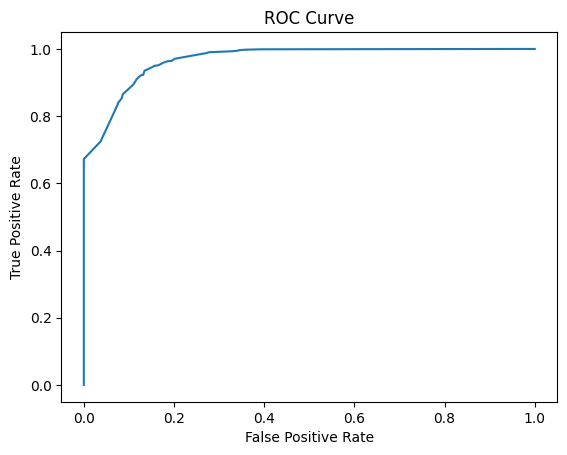

AUC Score:  0.9681765579758874


In [111]:
y_pred_proba = best_dt_classifier.predict_proba(X_test[X_train.columns])[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC Score: ", auc_score)

#### Matice záměn (Confusion matrix)

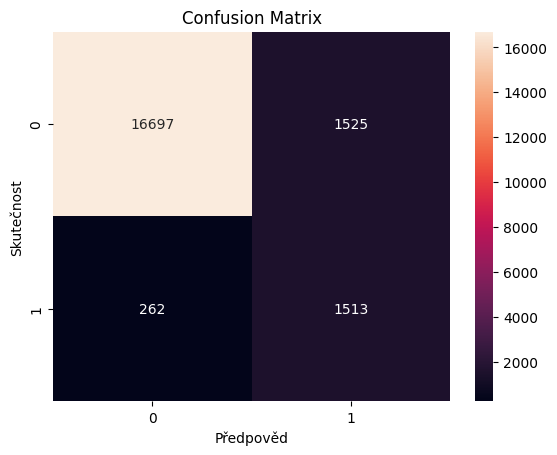

In [112]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Předpověd')
plt.ylabel('Skutečnost')
plt.title('Confusion Matrix')
plt.show()

### Classifier 2 (random forest)

* Compute accuracy and F1 score on test data (you can include also other measures)
* Show confusion matrix
* Multiply the predefined costs with the confusion matrix to get the overall cost of the model

#### Accuracy, precision, recall, F1 skóre a cena

In [113]:
y_pred = best_rf_classifier.predict(X_test[X_train.columns])
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
false_negative = confusion_matrix(y_test, y_pred)[1][0]
false_positive = confusion_matrix(y_test, y_pred)[0][1]
cost = false_negative * false_negative_cost + false_positive * false_positive_cost

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Cena: ", cost)

Accuracy:  0.9601940291043657
Precision:  0.7767100056529113
Recall:  0.7740845070422535
F1 Score:  0.7753950338600452
Cena:  999500


#### ROC křivka a AUC skóre

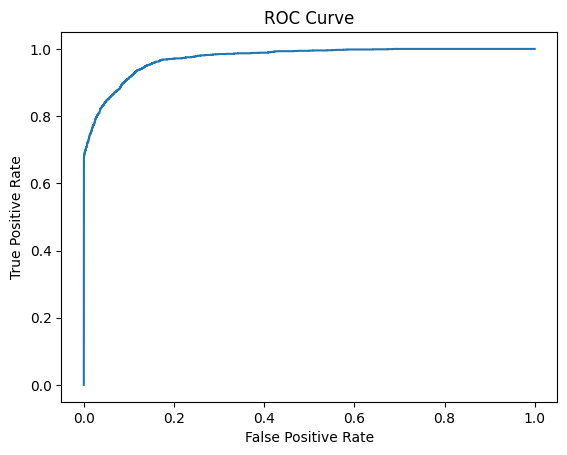

AUC Score:  0.9733508636055163


In [114]:
y_pred_proba = best_rf_classifier.predict_proba(X_test[X_train.columns])[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC Score: ", auc_score)

#### Matice záměn (Confusion matrix)

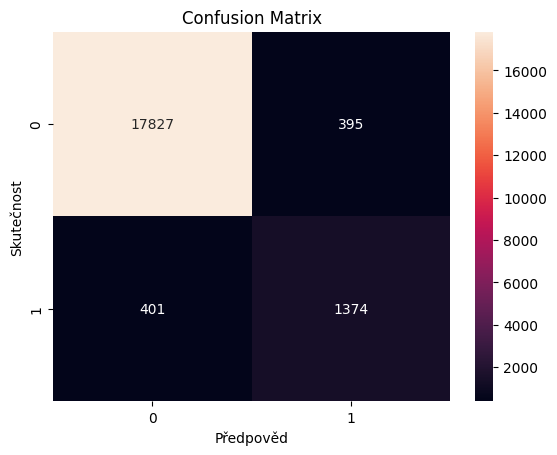

In [115]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Předpověd')
plt.ylabel('Skutečnost')
plt.title('Confusion Matrix')
plt.show()

### Classifier 3 (baseline)

* Compute accuracy and F1 score on test data (you can include also other measures)
* Show confusion matrix
* Multiply the predefined costs with the confusion matrix to get the overall cost of the model

#### Accuracy, precision, recall, F1 skóre a cena

In [116]:
accuracy = accuracy_score(y_test, y_baseLinePred)
precision = precision_score(y_test, y_baseLinePred)
recall = recall_score(y_test, y_baseLinePred)
f1 = f1_score(y_test, y_baseLinePred)
false_negative = confusion_matrix(y_test, y_baseLinePred)[1][0]
false_positive = confusion_matrix(y_test, y_baseLinePred)[0][1]
cost = false_negative * false_negative_cost + false_positive * false_positive_cost

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Cena: ", cost)

Accuracy:  0.9112366855028254
Precision:  0.0
Recall:  0.0
F1 Score:  0.0
Cena:  3550000


C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


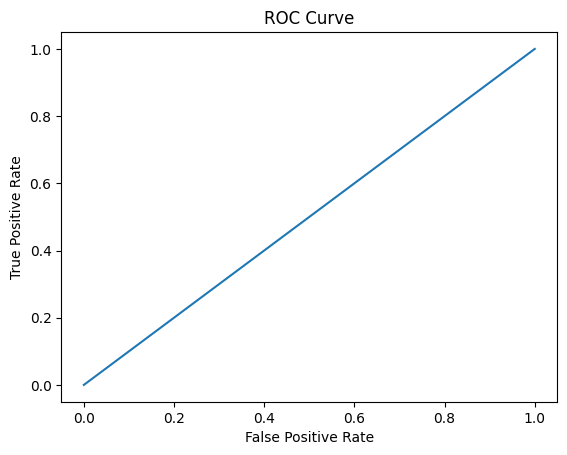

In [117]:
y_pred_proba = y_baseLinePred
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#### Matice záměn (Confusion matrix)

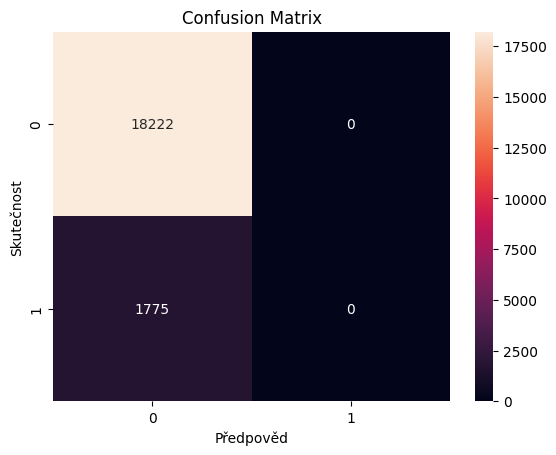

In [118]:
cm = confusion_matrix(y_test, y_baseLinePred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Předpověd')
plt.ylabel('Skutečnost')
plt.title('Confusion Matrix')
plt.show()

### Summary

* Which metric is most suitable for use for the current problem (accuracy, F-measure)?
* Compare the performance metrics for all types of models (e.g,. decision tree and forest). Which model is the best one?
* Combine (multiply) the predefined costs matrix with the values in the confusion matrix for each model. Which model is the best one? 


# Explanation

## Global explanation

### Classifier 1 - decision tree

* Visualize the decision tree
* Looking at the tree, list the most important attributes

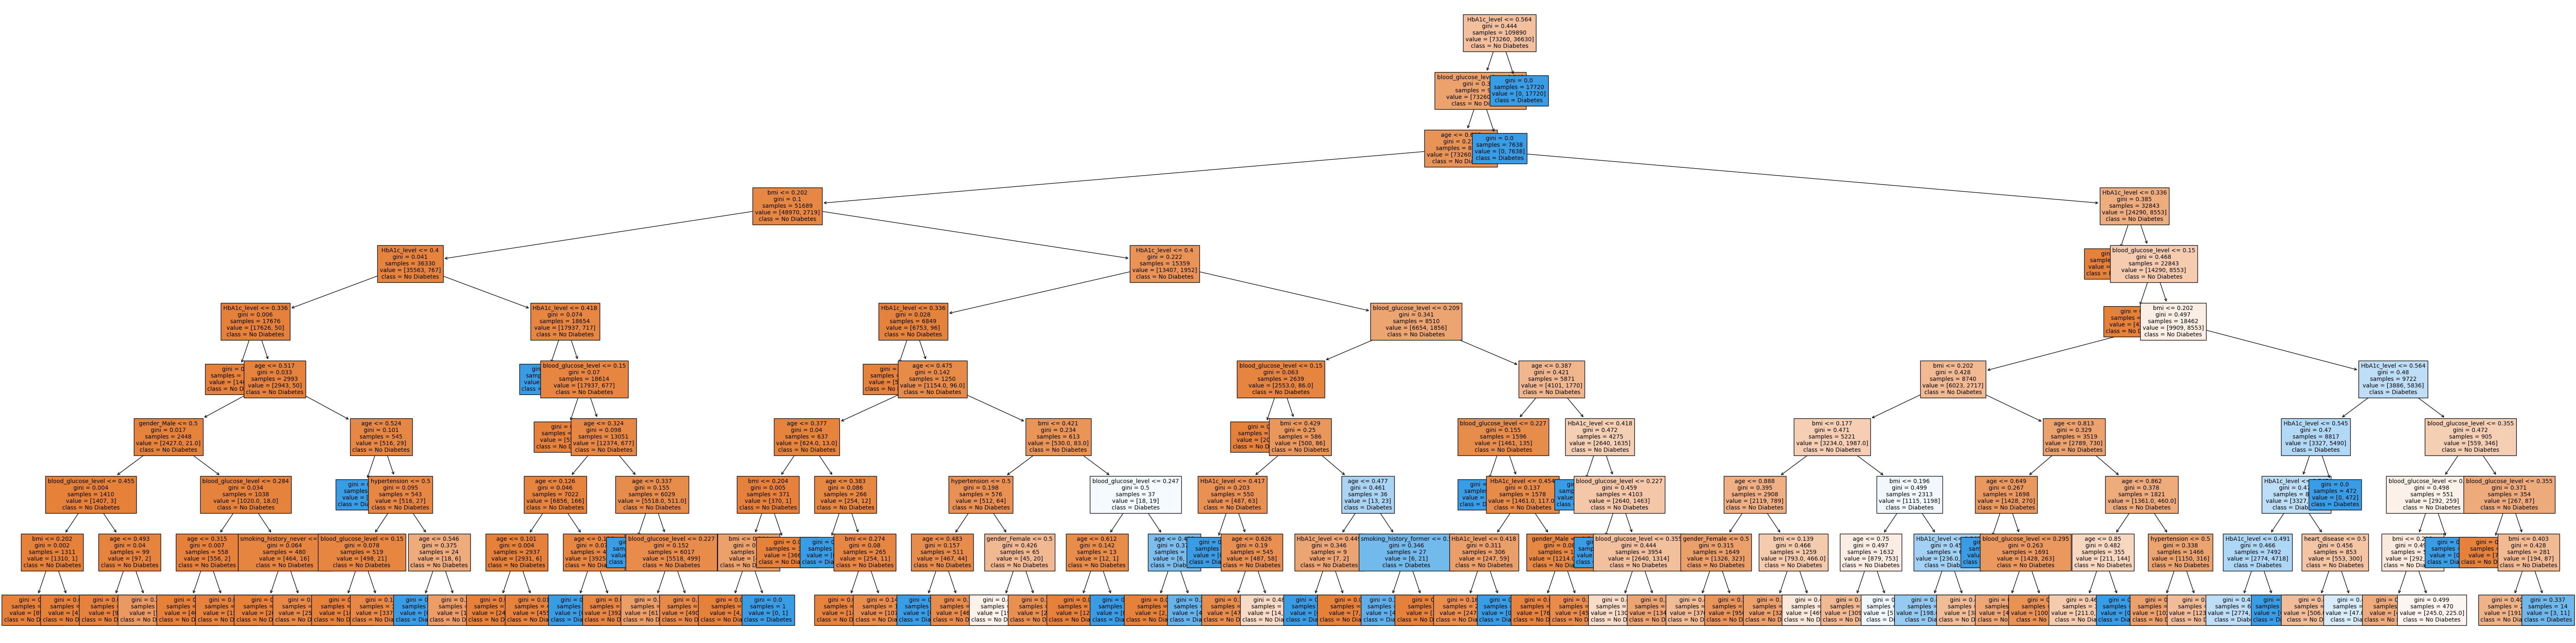

In [119]:
plt.figure(figsize=(80,20))
plot_tree(best_dt_classifier, feature_names=X_train.columns, filled=True, fontsize=10,class_names=['No Diabetes', 'Diabetes'])
plt.show()

### Classifier 2 - random forest

* Show the feature importance of variables in the forest

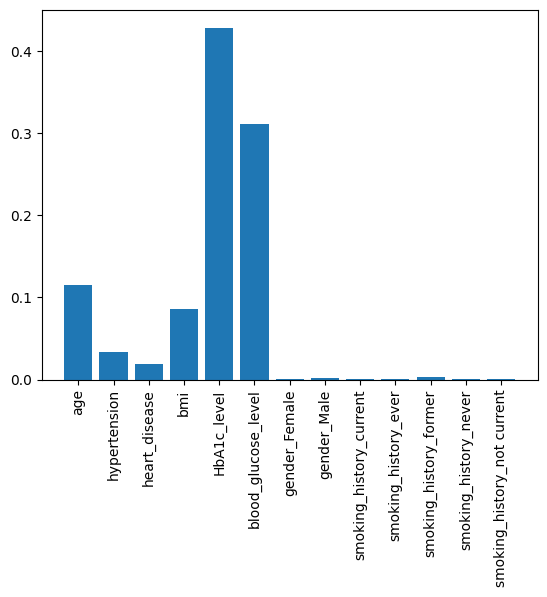

In [120]:
importance = best_rf_classifier.feature_importances_
plt.bar(X_train.columns, importance)
plt.xticks(rotation=90)
plt.show()

## Local explanation

* Show the *instance of interest* - a row in the dataframe
* Use both models to classify the chosen instance
* Do both models assign the same class?
* What is the confidence (probability) of the prediction?
* If you change the value of the attribute of interest in the instance of interest, how does the classification of the instance change? 

In [121]:
instance_of_interest = instance_of_interest[data.columns].values.reshape(1,-1)
instance_of_interest = pd.DataFrame(instance_of_interest, columns=data.columns)

print("Instance: \n",instance_of_interest)
instance_of_interest.drop('diabetes', axis=1,inplace = True)


instance_of_interest[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']] = scaler.fit(data[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']]).transform(instance_of_interest[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']])

instance_of_interest['gender_Female'] = 1
instance_of_interest['gender_Male'] = 0
instance_of_interest.drop('gender', axis=1, inplace=True)
instance_of_interest['smoking_history_never'] = 1
instance_of_interest['smoking_history_current'] = 0
instance_of_interest['smoking_history_former'] = 0
instance_of_interest['smoking_history_ever'] = 0
instance_of_interest['smoking_history_not current'] = 0
instance_of_interest.drop('smoking_history', axis=1, inplace=True)


decision_tree_output = best_dt_classifier.predict(instance_of_interest[X_train.columns])
random_forest_output = best_rf_classifier.predict(instance_of_interest[X_train.columns])

print("Decision Tree: ", decision_tree_output)
print("Random Forest: ", random_forest_output)


Instance: 
    gender   age hypertension heart_disease smoking_history    bmi HbA1c_level  \
0  Female  68.0            0             0         No Info  40.31         7.5   

  blood_glucose_level diabetes  
0                 260        1  
Decision Tree:  [1]
Random Forest:  [1]


# Conclusion
Summarize the results, answering questions such as:

1.	Which machine learning result has the highest value and is most interesting?

         Nelepší výsledek vrací random forest. Má celkově nejlepší metriky (charakterizováno F1 skórem) a důležité je že jeho cena je nenižší. 


2.	What setting provided the best result? 

         Nejlepší parametry pro random forest byly max_depth = 10 a n_estimators = 50. Použili jsme SMOTE upsampling který může být kontroverznější než jen zopakování méně zastoupených instancí ale výsledky byly velice podobné, jen v případě SMOTE a torchu lepší.

3.	Which attributes are the most important?

         Nejdůležitejšími atributy jsou blood glucose level a HbA1c level, což jsou oba ukazatele krevního cukru. Překvapivě atribut hisotire kouření byl modelem vyhodnocován jako téměř zbytečný.


# Optional parts

## Evaluation 

## Ablation study
* Classification: Quantify the effect of individual preprocessing steps (such as rescaling). How would the performance change if you have not performed this step.

        Při testech jestli upsamplovat nebo ne se skore modelu neměnilo tak moc jak bychom čekali, jeho cena ale byla znatelně horší. Když jsme vynechali normalizaci tak model byl jen o trochu horší, pravděpodobně tím, že výsledek je stále nejvíce ovlivněn atributy blood glucose level a HbA1c level
        
* Clustering: Try clustering with and without feature selection in the data preprocessing stage. Compare the results. What would be the impact on the result based on the Rand Index?

###  Optimization of threshold (optional)

* If you would change the probability (score) threshold for classification, would you obtain better results in terms of total costs? For which threshold? 

## Explanation

*	Apply ICE/IME/SHAPLEY/Anchors to explain the classification of the instance

# Final checklist

-	Are all preprocessing steps justified?
-	Did you try different metaparameter values where appropriate?
-	Are the results replicable? If you have the same data, does the report describe all steps in sufficient detail to obtain the same results as reported by the authors?
-	Were proper evaluation metrics selected? Are the results correctly interpreted?
-	Are all important steps explained and justified?
-	What is the quality of writing? Is the language clear and concise?


# Submission

* This .ipynb file with your code + its html version after the code was run (File-Save and export notebook as - html)
* Source data or a link to source data or source data being loaded from a url in the notebook
* Data files after preprorcessing (train.csv and test.csv)